# Exploring Ford GoBike System Data
## by Duyen Nguyen

## Preliminary Wrangling

The Ford GoBike (now Bay Wheels) System Datasets include data about trip duration, time of departure and arrival, starting point and destination as well as user-related data like gender, birth year, etc. of the Bay Wheels bikeshare program offered by Lyft in Bay Area. Datasets ranging from June 2017 to September 2019 were obtained from [Lyft's official website](https://www.lyft.com/bikes/bay-wheels/system-data). 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import glob
%matplotlib inline

In [2]:
#load all datasets into pandas dataframes and merge all dataframes
files = glob.glob('*.csv')

df = []
for file in files:
    data = pd.read_csv(file, encoding='iso-8859-1')
    df.append(data)
df = pd.concat(df, axis=0, ignore_index=True, sort=False)

/Users/duyennguyen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/duyennguyen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#overall look at dataset structure and components
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,Unnamed: 16,rental_access_method
0,598,2018-02-28 23:59:47.0970,2018-03-01 00:09:45.1870,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114.0,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,1988.0,Male,No,NaN,NaN
1,943,2018-02-28 23:21:16.4950,2018-02-28 23:36:59.9740,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,1987.0,Male,No,NaN,NaN
2,18587,2018-02-28 18:20:55.1900,2018-02-28 23:30:42.9250,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,1986.0,Female,No,NaN,NaN
3,18558,2018-02-28 18:20:53.6210,2018-02-28 23:30:12.4500,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,1981.0,Male,No,NaN,NaN
4,885,2018-02-28 23:15:12.8580,2018-02-28 23:29:58.6080,308.0,San Pedro Square,37.336802,-121.894090,297.0,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,1976.0,Female,Yes,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4256681 entries, 0 to 4256680
Data columns (total 18 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
Unnamed: 16                object
rental_access_method       object
dtypes: float64(7), int64(2), object(9)
memory usage: 584.6+ MB


Upon initial review of the dataset structure, colomn 'Unnamed: 16' stands out as irregular and requires a closer look.

In [5]:
df['Unnamed: 16'].value_counts()

app        25815
clipper     3809
Name: Unnamed: 16, dtype: int64

In [6]:
df['rental_access_method'].value_counts()

app        3379
clipper     514
Name: rental_access_method, dtype: int64

It turns out in one of the csv files, there is a column of data with the same values as column **'rental_access_method'** but this column does not have a name. Therefore, the **'Unnamed: 16'** column will be merged with **'rental_access_method'** to tidy up the final dataset.

In [7]:
df.duplicated().sum()

0

### What is the structure of your dataset?

> The final combined dataset contains data for  4,256,681 anonymized trips with attributes including bike ID, start time, end time, duration of trip in seconds; ID, name, longitude, latitude of start station and end station; user information i.e. birth year, gender, user type, rental access method and whether user belongs to the Bike Share for All program.

> There are two user types: Subscriber and Customer. User's genders include 'Male', 'Female' and 'Other'. Users can access the rental bikeshare program via the Lyft app or their own Clipper card. 

### What is/are the main feature(s) of interest in your dataset?

> The main interest in exploring this dataset is finding out how trip duration changes based on each day of the week, month and year. Another point of interest is the volume of trips taken each day, month and year. I would also like to determine whether user types, gender and age have any effect on trip duration. 


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> As a typical bike trip in a rental program lasts for a short amount of time, usually less than a day, the timestamp used for analyzing trends in number of trips and duration will be start time. Therefore, year, month, day of the week, and hour of the day will be extracted from the start timestamp. As mentioned above, user type, gender, age (derived from birth year) will be investigated for their relationship with trip duration. Longitude and latitude of start stations and end stations will be used to plot the journey of the most used bike in the system.

In [8]:
#convert start_time to datetime object to extract date and time
df['start_time'] = pd.to_datetime(df['start_time'])

In [9]:
#create new column for 'year'
df.loc[:, 'year'] = df['start_time'].apply(lambda x: x.year)

In [10]:
#create new column for 'month'
df.loc[:, 'month'] = df['start_time'].apply(lambda x: x.month)

In [11]:
#create new column for day of the week
df.loc[:, 'day_of_the_week'] = df['start_time'].apply(lambda x: x.weekday())

In [12]:
#create new column for hour of the day
df.loc[:, 'hour'] = df['start_time'].apply(lambda x: x.hour)

In [13]:
#replace numerical values with names of days of the week and months
df['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 
                                                              'July', 'August', 'September', 'October', 'November', 'December'], inplace=True)

df['day_of_the_week'].replace([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                                      'Saturday', 'Sunday'], inplace=True)

In [15]:
#convert columns related to IDs and year to string type
df.bike_id = df.bike_id.astype(str)
df.start_station_id = df.start_station_id.astype(str)
df.end_station_id = df.end_station_id.astype(str)
df.year = df.year.astype(str)

In [16]:
#fill NaN values in rental_access_method with values in Unnamed: 16 to merge the two columns
df['rental_access_method'] = df['rental_access_method'].fillna(df['Unnamed: 16'])

In [17]:
#drop the extra unnamed column
df.drop(columns=['Unnamed: 16'], inplace=True)

In [18]:
#reset index
df.reset_index(drop=True, inplace=True)

In [19]:
#create new column for member's age
df['member_age'] = 2019 - df['member_birth_year']

In [20]:
#unify values of gender into 3 categories: Male, Female and Other
df['member_gender'].replace(['M', 'F', 'O'], ['Male', 'Female', 'Other'], inplace=True)
df['member_gender'].replace('?', 'Other', inplace=True)

In [21]:
#overview of dataset after preliminary data wrangling
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4256681 entries, 0 to 4256680
Data columns (total 22 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
rental_access_method       object
year                       object
month                      object
day_of_the_week            object
hour                       int64
member_age                 float64
dtypes: datetime64[ns](2), float64(6), int64(2), object(12)
memory usage: 714.5+ MB


## Univariate Exploration


In [22]:
#overview of dataset after preliminary data wrangling
df.describe()

,duration_sec,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,hour,member_age
count,4.256681e+06,4.256681e+06,4.256681e+06,4.256681e+06,4.256681e+06,3.890680e+06,4.256681e+06,3.890680e+06
mean,8.634332e+02,3.776759e+01,-1.223513e+02,3.776759e+01,-1.223502e+02,1.983521e+03,1.354628e+01,3.547891e+01
std,2.346951e+03,1.055024e-01,1.605519e-01,1.296368e-01,2.922881e-01,1.040687e+01,4.752498e+00,1.040687e+01
min,6.000000e+01,0.000000e+00,-1.224737e+02,0.000000e+00,-1.224737e+02,1.878000e+03,0.000000e+00,1.800000e+01
25%,3.560000e+02,3.777106e+01,-1.224117e+02,3.777106e+01,-1.224108e+02,1.978000e+03,9.000000e+00,2.800000e+01
50%,5.640000e+02,3.778107e+01,-1.223974e+02,3.778107e+01,-1.223971e+02,1.986000e+03,1.400000e+01,3.300000e+01
75%,8.820000e+02,3.779625e+01,-1.222912e+02,3.779728e+01,-1.222914e+02,1.991000e+03,1.700000e+01,4.100000e+01
max,8.636900e+04,4.551000e+01,0.000000e+00,4.551000e+01,0.000000e+00,2.001000e+03,2.300000e+01,1.410000e+02


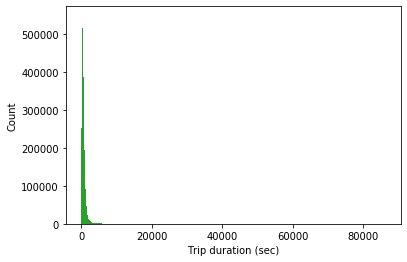

In [23]:
#plotting distribution of trip durations
color = sb.color_palette()[2]
bin_edges = np.arange(0, df['duration_sec'].max(), 100)
plt.hist(df['duration_sec'], bins=bin_edges, color=color)
plt.xlabel('Trip duration (sec)')
plt.ylabel('Count');

It appears that trip duration has a very large range in values; thus, smaller bin size will be used to have a better look at distribution of trip duration values. As there are outliers with extra large values, the next plot will be limited to trips lasting under 6,000 seconds.

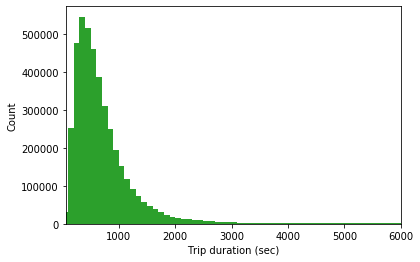

In [24]:
bin_edges = np.arange(0, df['duration_sec'].max(), 100)
plt.hist(df['duration_sec'], bins=bin_edges, color=color);
plt.xlim(59, 6000)
plt.xlabel('Trip duration (sec)')
plt.ylabel('Count');

The data appears to be extremely skewed to the right with a long tail, suggesting there are many more shorter trips than trips longer than 3,000 seconds.

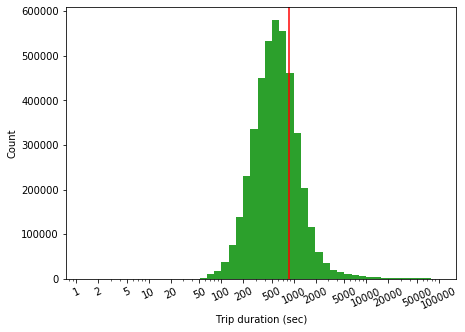

In [25]:
bin_edges = 10 ** np.arange(0.1, np.log10(df['duration_sec'].max())+0.1, 0.1)
plt.figure(figsize=[7, 5])
plt.hist(df['duration_sec'], bins=bin_edges, color=color);
x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
plt.xscale('log')
plt.xticks(x_ticks, x_ticks, rotation=25);
plt.axvline(x=df['duration_sec'].mean(), color='red')
plt.xlabel('Trip duration (sec)')
plt.ylabel('Count');

After a log transformation on the x axis, the data appears to be normally distributed with a peak at about 500 seconds, indicating the typical duration for a bike trip. However, because of the outliers, the average trip duration is about 800 seconds. 

Next up will be a brief look into the demographics of users in the bikeshare system i.e. gender, age and user type.

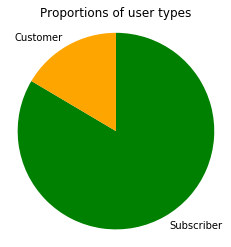

In [26]:
sorted_counts = df['user_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, colors=['green', 'orange']);
plt.axis('square')
plt.title('Proportions of user types');

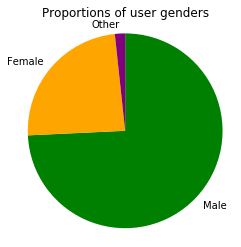

In [27]:
gender_counts = df['member_gender'].value_counts()
plt.pie(gender_counts, labels = gender_counts.index, startangle = 90,
        counterclock = False, colors=['green', 'orange', 'purple']);
plt.axis('square')
plt.title('Proportions of user genders');

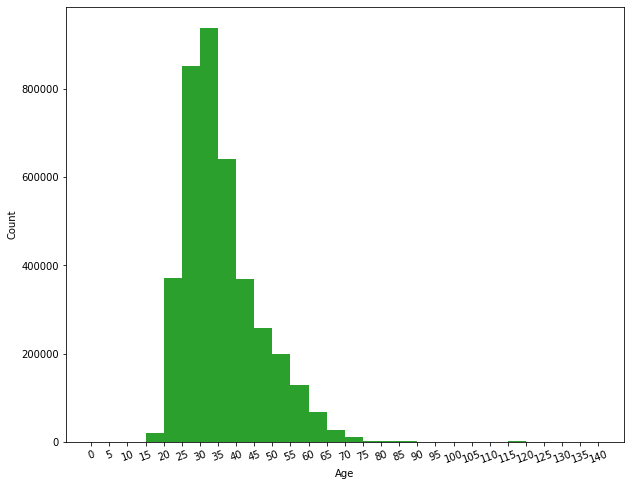

In [28]:
plt.figure(figsize=[10, 8])
bin_age = np.arange(0, df['member_age'].max(), 5)
plt.hist(data=df, x='member_age', bins=bin_age, color=color)
x_ticks = np.arange(0, df['member_age'].max(), 5)
plt.xticks(x_ticks, [format(x).rstrip('0').rstrip('.') for x in x_ticks], rotation=20)
plt.xlabel('Age')
plt.ylabel('Count');

The vast majority of users are male subscribers while females and other genders account for about a quarter of the user population. Most users are in their 20s, 30s, and 40s. However, there are some users with age over 90. This is almost impossible to happen and is likely to be errors in user input. These data will be removed from the dataset to avoid skweing further analysis.

In [29]:
#remove trips with users over 90 years old
df.drop(index=df[df.member_age > 91].index, inplace=True)
df.reset_index(drop=True, inplace=True)

Finally, we will look at the volume of trips taken in each year, month, day of the week and hour of the day. 

In [30]:
#convert year, month, and day_of_the_week into ordered categorical types
ordinal_var_dict = {'year': ['2017','2018','2019'],
                    'month':['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                            'October', 'November', 'December'],
                    'day_of_the_week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

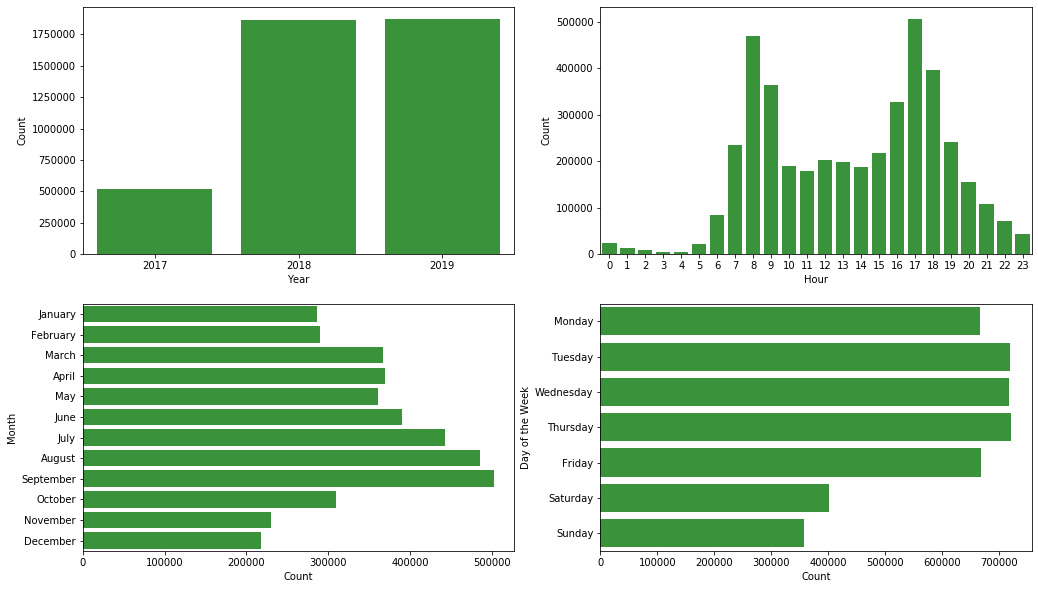

In [31]:
#plot volume of trips taken in each year, month, day of the week and hour of the day
plt.figure(figsize=[17, 10])

plt.subplot(2, 2, 1)
sb.countplot(data=df, x='year', color=color)
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
sb.countplot(data=df, y='month', color=color)
plt.xlabel('Count')
plt.ylabel('Month')

plt.subplot(2, 2, 4)
sb.countplot(data=df, y='day_of_the_week', color=color)
plt.xlabel('Count')
plt.ylabel('Day of the Week')

plt.subplot(2, 2, 2)
sb.countplot(data=df, x='hour', color=color)
plt.xlabel('Hour')
plt.ylabel('Count');

As the datasets obtained only started in June 2017, the number of trips taken in 2017 is significantly lower than those of 2018 and 2019, which are almost equal to each other. However, data in 2019 ends in September so it is safe to assume that the number of trips have been steadily increasing each year. Trip volume increases towards the summer months and peaks in September before sharply decreases towards the end of the year. This trend makes perfect sense due to the warmer summer weather that is optimal for biking, while the colder winter weather means users tend to opt for other forms of transportation. 

On a daily basis, the majority of trips tend to fall on the beginning of the week, peaking on Thursday, and plunges on weekends. This trend coincides with the normal work week from Monday to Friday, which also explains the bimodal distribution when it comes to time of the day trips are taken. Trip volume reaches two peaks consecutively at the beginning of a workday at 8 AM and again at the end of the workday at 5 PM. There is also a slight increase during lunch hours.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Trip duration in seconds has a very large range from 60 to well over 86,000, which makes the initial plot heavily skewed to the right with a very long tail. Therefore, I performed a log transformation on the x axis. The resulting histogram is unimodal and normally distributed  with a peak at around 500 seconds. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> When exploring the age of users, I found a few outliers with values above 90, which is far past the normal age of sufficient physical ability to ride a bike. This is likely due to error in user input; thus, data related to these trips will be removed from the dataset.

## Bivariate Exploration


As seen in the Univariate Exploration section, the vast majority of trip durations are under 2,000 seconds. Therefore, analysis in trip duration in this section will be limited to this segment to speed up the plotting process. First, we will look at the relationships between duration and year, month and day of the week.

<Figure size 720x720 with 0 Axes>

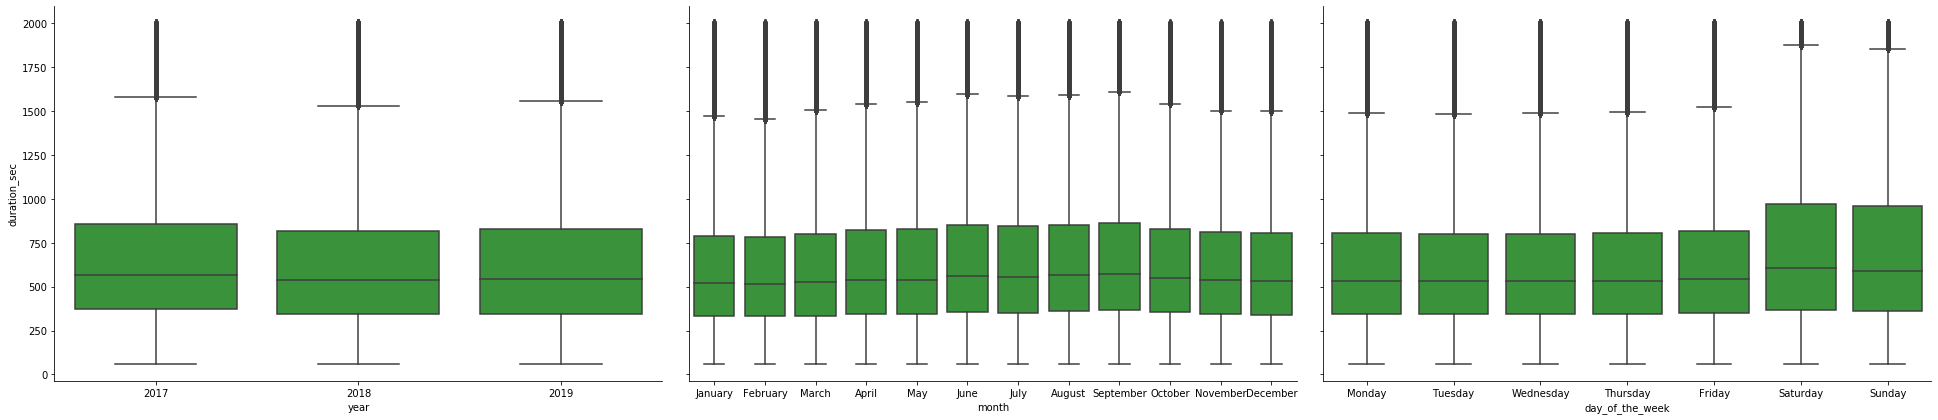

In [32]:
#Box plots showing how duration varies each year, month and day of the week
duration_majority = df[df.duration_sec <= 2000]
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y, color = color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = duration_majority, y_vars = ['duration_sec'], x_vars = ['year', 'month', 'day_of_the_week'],
                height = 6, aspect = 1.5)
g.map(boxgrid)
plt.show();

As expected, the average trip duration remain relatively the same over the years. During each year, trips tend to be longer during the summer months. On a daily scale, weekend trips are significantly longer than weekday trips. This could signify the difference in purpose as weekday trips are potentially more task-oriented while weekend trips can be more leisure-oriented.

Next, we will look at relationships between duration and demographics attributes like user type, gender and age.

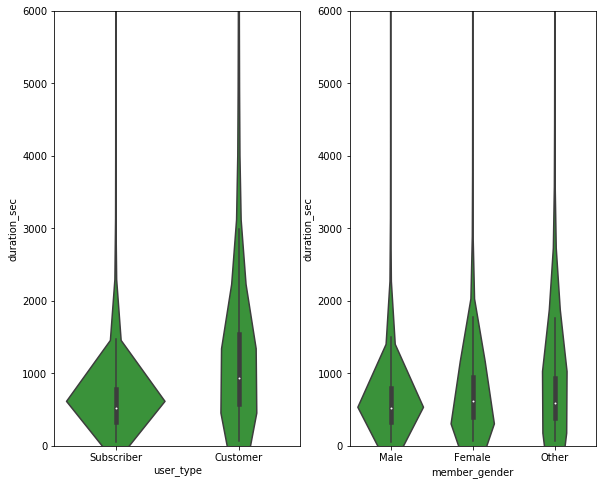

In [33]:
#Violin plots for relationships between duration, age, user type, and gender
#A sample of 100,000 data points is used to speed up the plotting process
sample = df.sample(100000, replace=True)
plt.figure(figsize=[15, 8])
plt.subplot(1, 3, 1)
sb.violinplot(data=sample, x='user_type', y='duration_sec', color=color)
plt.ylim(0, 6000);

plt.subplot(1, 3, 2)
sb.violinplot(data=sample, x='member_gender', y='duration_sec', color=color)
plt.ylim(0, 6000);

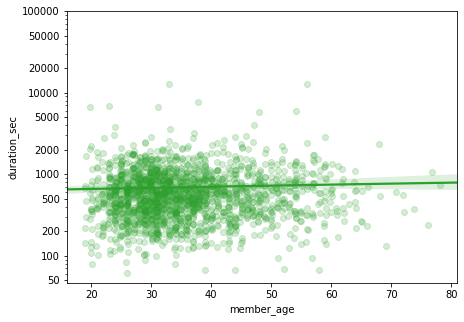

In [34]:
#scatter plot for the relationship between duration and member's age
sample2 = df.sample(2000, replace=True)
plt.figure(figsize=[7, 5])
sb.regplot(data=sample2, x='member_age', y='duration_sec', scatter_kws={'alpha':1/5}, color=color, x_jitter=0.2,
          y_jitter=0.2)
plt.yscale('log')
y_ticks = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
plt.yticks(y_ticks, y_ticks);

Between subscribers and customers, the former tend to take much shorter trips averaging 500 seconds, while the latter's average trip duration is about 750 seconds. This seems counter-intuitive since subscribers paying either monthly or yearly fee get to ride the first 45 minutes, or 2,700 seconds, for free, which should encourage them to take longer rides. A potential explanation for this difference is a subscriber possibly is willing to commit to a monthly/yearly payment because of higher frequency of usage, which means a wider variety of trip purposes and shorter trip durations. This, however, requires more data in user behaviors to come to a more definite conclusion.

Female users and users identify as 'Other' appear to take longer trips than males. There seems to be no correlation between trip duration and member's age, contrary to my initial assumption that trip duration decreases with age.

Finally, in this section, I will attempt to visualize a 'map' of all the locations that users frequent in the Bay Area. The nature of a bikeshare program is a bike is picked up at one station and dropped of at another station. Therefore, the end station of one trip is highly likely the start station of the next trip for the same bike. Plotting all the start station locations, consequently, can give a roughly accurate map of all the locations users tend to visit.

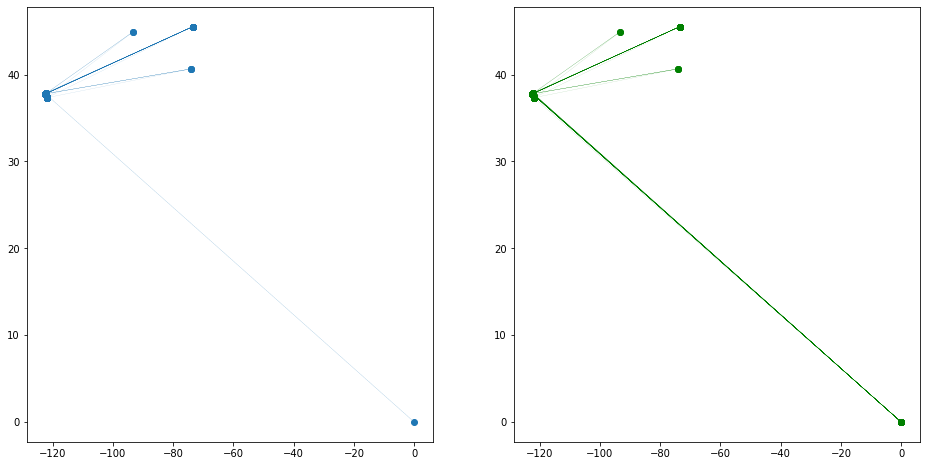

In [35]:
#plot user locations using start station and end station's longitude and latitude
plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
plt.plot(df.start_station_longitude, df.start_station_latitude, marker='o', linestyle='dashed', linewidth=0.1);

plt.subplot(1, 2, 2)
plt.plot(df.end_station_longitude, df.end_station_latitude, marker='o', linestyle='dashed', color='green', linewidth=0.1);

The initial plot show many outlier locations with longitudes and latitudes outside of the Bay Area. These locations are possibly test locations, hence, will be removed from the dataset to ensure integrity. 

In [36]:
#remove data points with locations outside of Bay Area
df[df.start_station_longitude > -100].index.tolist()
df.drop(index=df[df.start_station_longitude > -100].index.tolist(), inplace=True)
df.reset_index(drop=True, inplace=True)

As the number of datapoints is humongous, only top 20 most used bikes in the dataset will be selected to plot the map of locations.

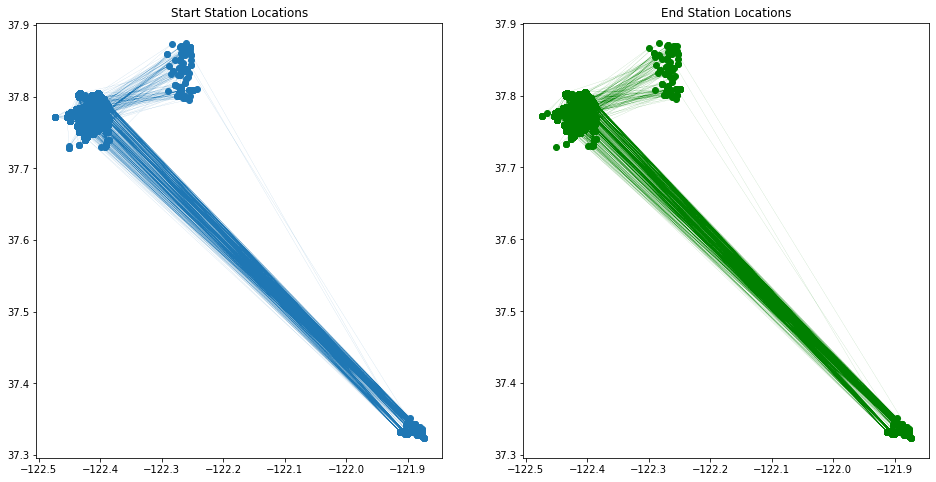

In [37]:
most_used_bikes_list = df.bike_id.value_counts()[:19].index.tolist()

most_used_bikes = df[df.bike_id.apply(lambda x: x in most_used_bikes_list) == True]

plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
plt.plot(most_used_bikes.start_station_longitude, most_used_bikes.start_station_latitude, marker='o', linestyle='dashed', linewidth=0.1)
plt.title('Start Station Locations');

plt.subplot(1, 2, 2)
plt.plot(most_used_bikes.end_station_longitude, most_used_bikes.end_station_latitude, marker='o', linestyle='dashed', color='green', linewidth=0.1)
plt.title('End Station Locations');

Based on the longitudes and latitudes of these locations, it can be inferred that most trips are made between three major cities of Bay Area: San Francisco, Oakland and San Jose, with the most trips made between San Francisco and San Jose, followed by San Francisco - Oakland and Oakland - San Jose.

Let's take a closer look at the most used bike in the system to see its whole journey.

In [38]:
#find the most used bike in the system
print(most_used_bikes_list)

['2692', '2174', '1396', '1161', '3379', '232', '3146', '2545', '3105', '2387', '746', '126', '2941', '1543', '2497', '3381', '2753', '1511', '2663']


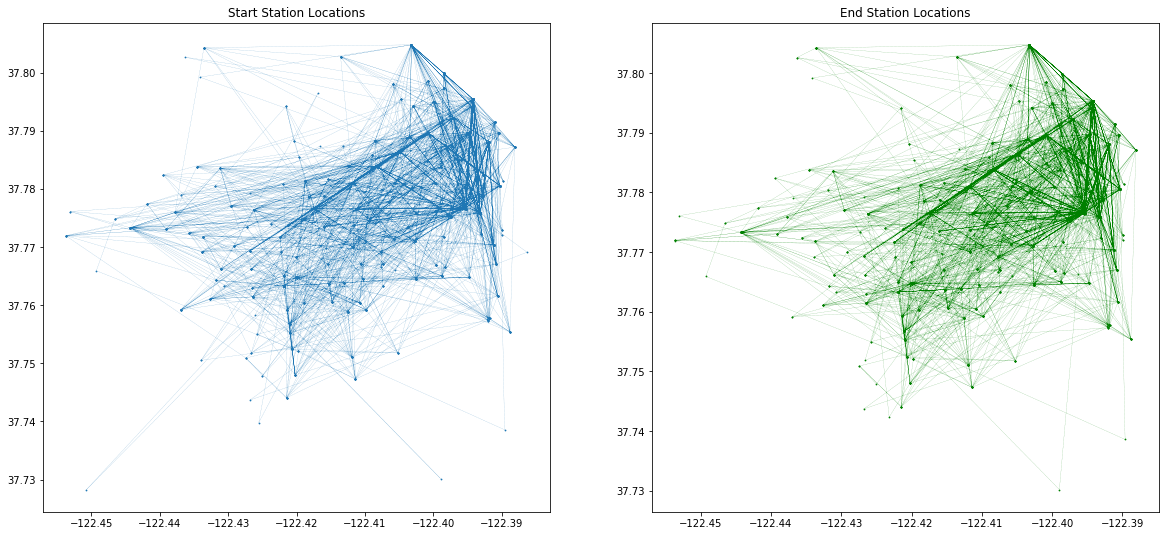

In [39]:
#plot the map of locations visited with bike 2692
bike_2692 = df[df.bike_id == '2692']

plt.figure(figsize=[20, 9])
plt.subplot(1, 2, 1)
plt.plot(bike_2692.start_station_longitude, bike_2692.start_station_latitude, marker='o', markersize=0.8, 
         linestyle='dashed', linewidth=0.15)
plt.title('Start Station Locations');

plt.subplot(1, 2, 2)
plt.plot(bike_2692.end_station_longitude, bike_2692.end_station_latitude, marker='o', markersize=0.8,
         linestyle='dashed', color='green', linewidth=0.15)
plt.title('End Station Locations');

The resulting plots show a more detailed look into the most frequented locations in the Bay Area, especially in the three major cities San Francisco, San Jose and Oakland.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Duration of a trip apparently has a correlation with the month and day of the week it is taken. Average trip duration remains constant each year. However, on the monthly level, summer months from June to September see longer trips than winter months. Weekend trips, on average, are significantly longer than weekday trips. This observation, together with the plots for trip volumns in the Univariate section, lead to another interesting observation. It seems like on a weekly basis, number of trips and average duration of trips are potentially inversely correlated to each other. This point can be further investigated in the Multivariate section.

> It appears that most subscriber take much shorter trips than non-subscriber. Female users and users identify as 'Other' appear to take longer trips than males. However, it is apparent that there is no correlation between user's age and trip duration.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I was able to plot a 'map' of the most visited stations using the longitudes and latitudes of start stations and end stations to visualize the journey taken by the most used bikes in the bikeshare system. Most trips are between the three major cities of Bay Area: San Francisco, San Jose and Oakland. While attempting to plot this feature, I was also able to detect locations with ambiguous coordinates outside of the Bay Area and removed them from the dataset.

## Multivariate Exploration


In this section, we will take a closer look into changes in trip duration and trip volume on a weekly basis to determine whether there is a negative relationship between these two features.

/Users/duyennguyen/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


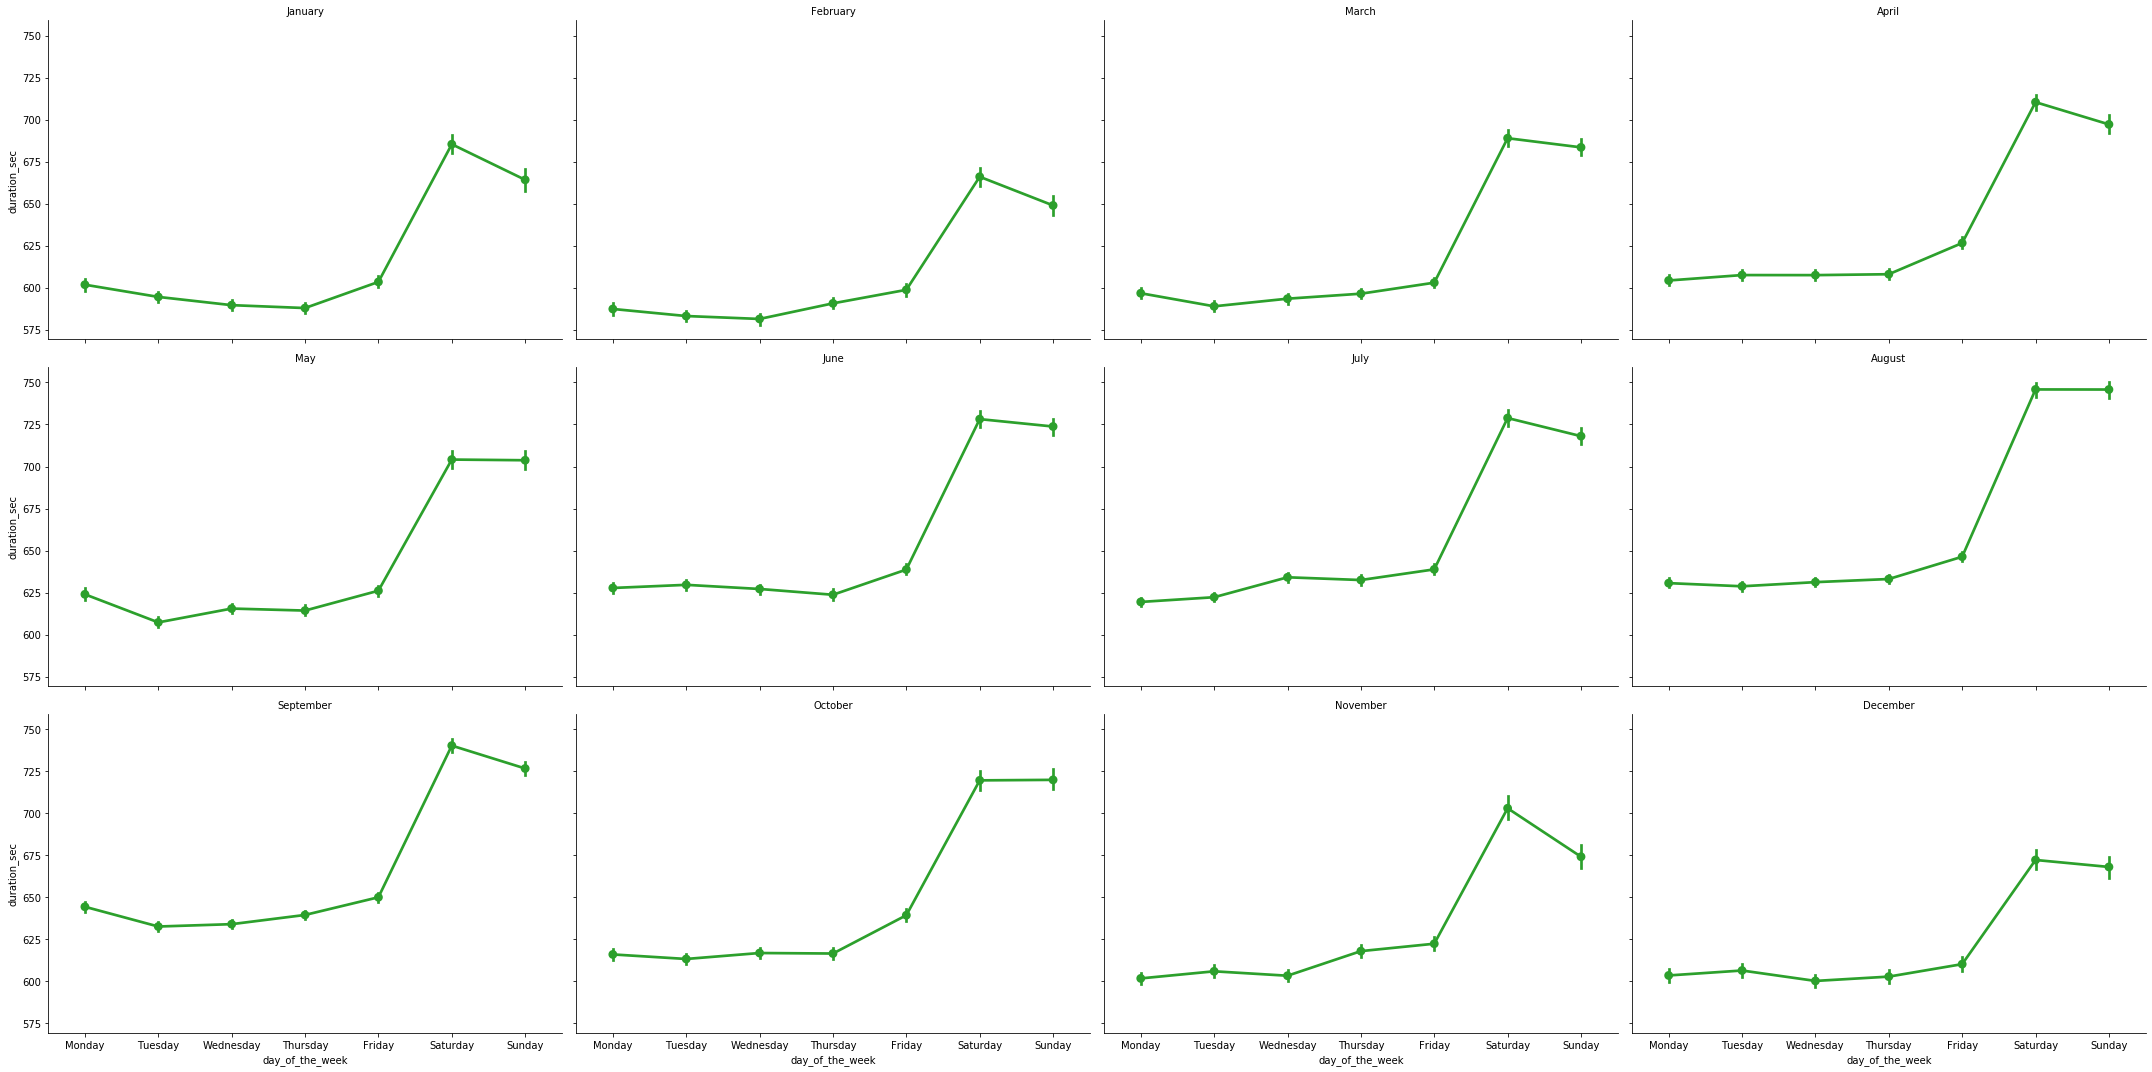

In [40]:
#plot changes of trip duration over the course of a week for each month
g = sb.FacetGrid(data = duration_majority, col = 'month', col_wrap = 4, height = 5, aspect=1.5)
g.map(sb.pointplot, 'day_of_the_week', 'duration_sec', color=color)
g.set_titles('{col_name}');

/Users/duyennguyen/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x1296 with 0 Axes>

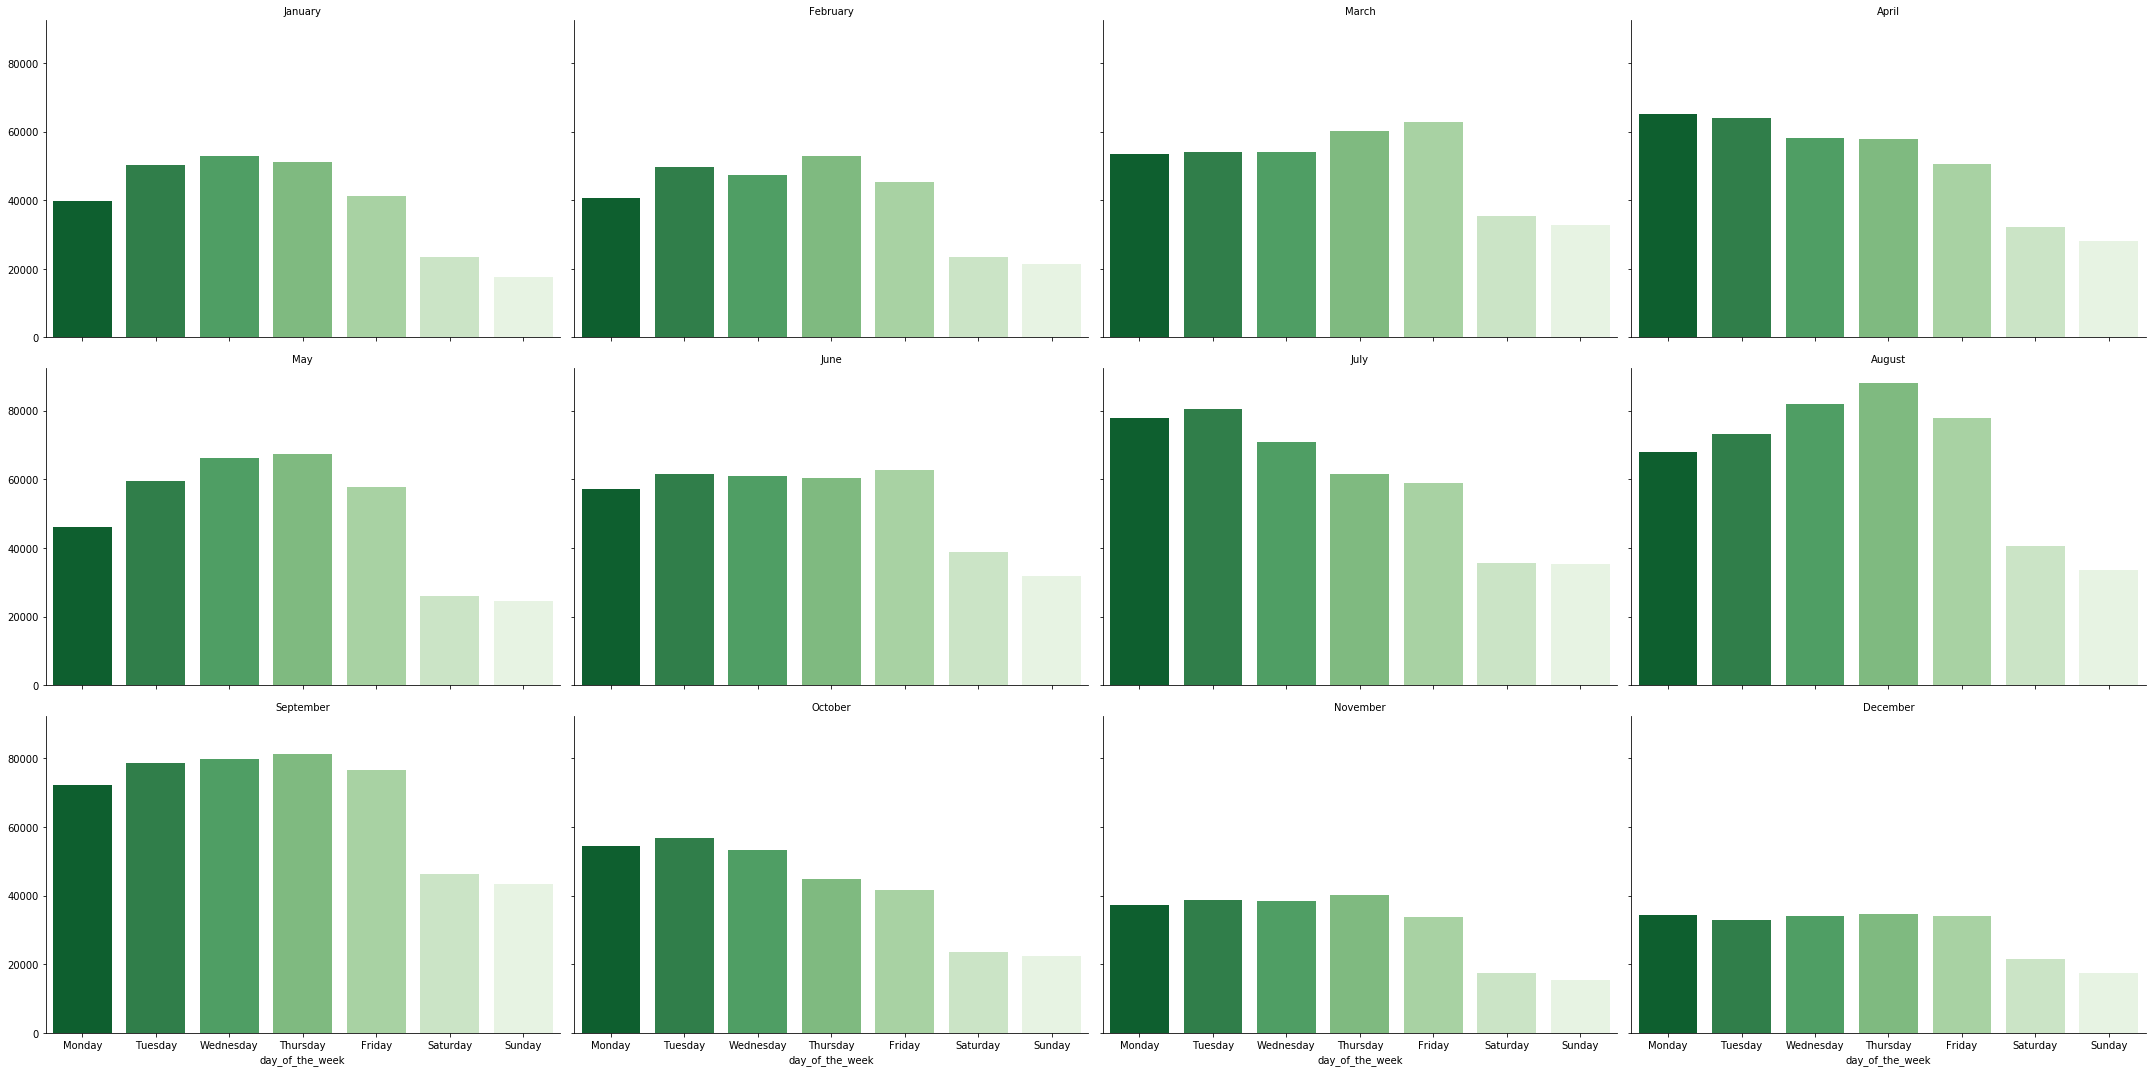

In [41]:
#plot changes in number of trips over the course of a week for each month
plt.figure(figsize=[20, 18])
g = sb.FacetGrid(data = duration_majority, col = 'month', col_wrap = 4, height = 5, aspect=1.5)
g.map(sb.countplot, 'day_of_the_week', palette='Greens_r')
g.set_titles(col_template='{col_name}');

As observed in previous sections, average duration of trips tend to vary slightly at the beginning of the week and steadily increases towards the weekend. Meanwhile, number of trips on each day sees the opposite trend, decreasing slightly on Friday, significantly on Saturday and hitting bottom on Sunday. We can see this relationship clearer in a scatterplot.

In [42]:
#create new dataframe and plot for relationship between duration and volume in each week
day_count = df.groupby(['day_of_the_week'])['day_of_the_week'].count().values
daily_duration = df.groupby(['day_of_the_week'])['duration_sec'].mean().values
day_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
d = {'day_count':day_count, 'daily_duration':daily_duration, 'day_of_the_week':day_of_the_week}
data = pd.DataFrame(d)

In [43]:
data

,day_count,daily_duration,day_of_the_week
0,667663,791.604654,Monday
1,719699,770.757157,Tuesday
2,717782,771.997058,Wednesday
3,721368,784.904366,Thursday
4,668139,830.191616,Friday
5,401397,1195.060912,Saturday
6,357943,1216.419226,Sunday


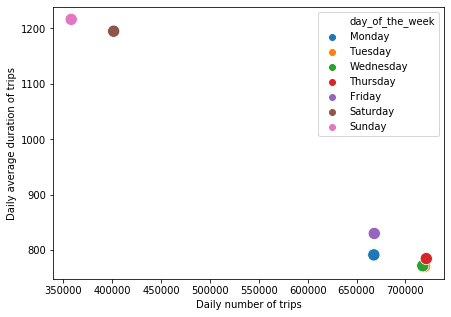

In [44]:
plt.figure(figsize=[7, 5])
sb.scatterplot(data=data, x='day_count', y='daily_duration', hue='day_of_the_week', s=150)
plt.xlabel('Daily number of trips')
plt.ylabel('Daily average duration of trips');

Although the negative correlation between these two features is relatively weak, this observation is helpful in gaining more insights into user behavior.

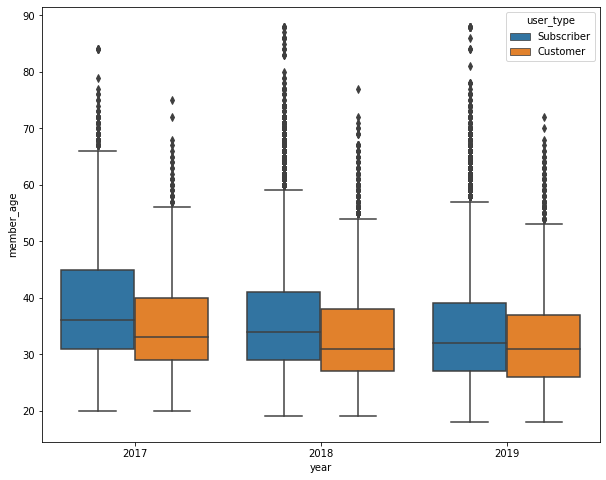

In [45]:
#plot the relationship between user type and member's age over the years with a sample size of 100,000
plt.figure(figsize=[10, 8])
sb.boxplot(data=sample, x='year', y='member_age', hue='user_type');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The observation about the negative correlation between number of trips taken each day of the week and the average duration of trips is reinforced in this section. However, this phenomenon is only applicable to the second half of the week; as in the first half, changes in trips duration and volume are more likely to be affected by the month in which trips are taken.

### Were there any interesting or surprising interactions between features?

> Upon a deeper look into demographics data, an interesting trend was found in member's age over the years. It appears that users of the Bay Wheels program are getting younger year after year. This reflects a change in awareness to the bikeshare program of the younger population. 